In [83]:
from pathlib import Path
from bold_dementia.utils.configuration import get_config
from neuroginius.atlas import Atlas
from neuroginius.plotting import plot_matrix
config = get_config()

conn_dir = config["connectivity_matrices"]
ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

In [84]:
import joblib
import pandas as pd
import numpy as np

def make_longitudinal_data(conn_dir, atlas, k):
    matrices = joblib.load(f"{conn_dir}/atlas-{atlas}_gpugin/connectivities.joblib")
    metadata = pd.read_csv(f"{conn_dir}/atlas-{atlas}_gpugin/metadata.csv", index_col=0)
    labels = pd.read_csv(f"/georges/memento/BIDS/cluster_{k}_labels.csv", index_col=0)


    metadata = metadata.merge(
        right=labels,
        how="left", # Preserves order of the left key
        on="NUM_ID",
        validate="many_to_one"
    )

    no_psych_mask = metadata.cluster_label.isna()
    print(
        f"Dropping {no_psych_mask.sum()} subjects because of lacking MMMSE"
    )

    metadata = metadata[np.logical_not(no_psych_mask)]
    matrices = matrices[np.logical_not(no_psych_mask)]

    return matrices, metadata

In [85]:
matrices, metadata = make_longitudinal_data(conn_dir, "schaefer200", 3)
metadata = metadata.reset_index(drop=True)

Dropping 22 subjects because of lacking MMMSE


In [86]:
# We look for subjects which have M000 and M048
end_msk = (metadata.cluster_label == 1) & (metadata.ses == "M048")
middle_msk = (metadata.cluster_label == 1) & (metadata.ses == "M024")
start_msk = (metadata.cluster_label == 1) & (metadata.ses == "M000")

end_subjects = metadata.loc[end_msk, "sub"].values
middle_subjects = metadata.loc[middle_msk, "sub"].values
start_subjects = metadata.loc[start_msk, "sub"].values

complete_subjects = sorted(
    tuple(set(list(end_subjects)).intersection(set(start_subjects)).intersection(set(middle_subjects)))
)

complete_subj_msk = metadata["sub"].isin(complete_subjects)
idx_48 = metadata[(metadata.ses == "M048") & complete_subj_msk].index.values
idx_24 = metadata[(metadata.ses == "M024") & complete_subj_msk].index.values
idx_00 = metadata[(metadata.ses == "M000") & complete_subj_msk].index.values


In [118]:
from nilearn.connectome import sym_matrix_to_vec
mat_mask = (joblib.load('output/haufe_steep.joblib'))# - joblib.load('output/haufe_slow.joblib')) * 1000
dir_vec = sym_matrix_to_vec(mat_mask)

pos_msk = np.where(mat_mask > 0, mat_mask, 0)
neg_msk = np.where(mat_mask < 0, mat_mask, 0)

pos_feats_48 = sym_matrix_to_vec((matrices[idx_48, ...] * pos_msk)).mean(axis=1)
pos_feats_24 = sym_matrix_to_vec((matrices[idx_24, ...] * pos_msk)).mean(axis=1)
pos_feats_00 = sym_matrix_to_vec((matrices[idx_00, ...] * pos_msk)).mean(axis=1)

neg_feats_48 = sym_matrix_to_vec((matrices[idx_48, ...] * neg_msk)).mean(axis=1)
neg_feats_24 = sym_matrix_to_vec((matrices[idx_24, ...] * neg_msk)).mean(axis=1)
neg_feats_00 = sym_matrix_to_vec((matrices[idx_00, ...] * neg_msk)).mean(axis=1)

In [119]:
pos_hue = np.full(pos_feats_00.shape, "steep > slow")
neg_hue = np.full(pos_feats_00.shape, "steep < slow")

In [120]:
hue = np.concatenate((pos_hue, neg_hue))
M000 = np.concatenate((pos_feats_00, neg_feats_00))
M024 = np.concatenate((pos_feats_24, neg_feats_24))
M048 = np.concatenate((pos_feats_48, neg_feats_48))

In [121]:
df = pd.DataFrame(
    np.stack(
        (M000, M024, M048),
        axis=0).T, 
    columns=["M000", "M024", "M048"]
)
df["pattern direction"] = hue

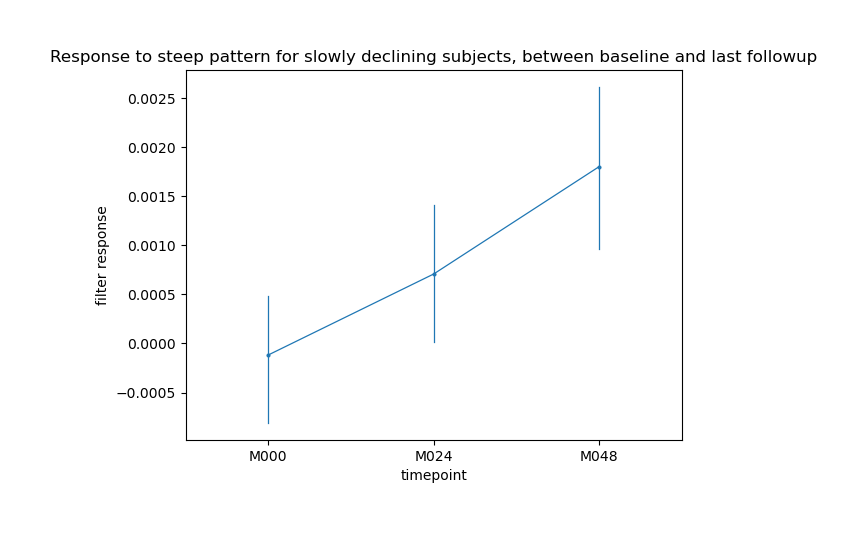

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
m = df.melt(id_vars="pattern direction", value_name="filter response", var_name="timepoint")
#sns.stripplot(m, x="timepoint", y="filter response")
sns.pointplot(m, x="timepoint", y="filter response")# hue="pattern direction", palette=['tab:red', 'tab:blue'])
plt.title("Response to steep pattern for slowly declining subjects, between baseline and last followup")
plt.show()